In [14]:
## importing necessary dependies

import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from obspy.geodetics.base import gps2dist_azimuth

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import RFE

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#from tsfresh import extract_features
#from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
import time
import pygmt
import matplotlib
import random

In [15]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['font.weight'] = 'bold'

In [16]:
iq_lats = pd.read_csv('icequakes_catalog.csv')['latitude']
iq_lons = pd.read_csv('icequakes_catalog.csv')['longitude']

eq_lats = pd.read_csv('earthquakes_catalog.csv')['latitude']
eq_lons = pd.read_csv('earthquakes_catalog.csv')['longitude']

stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])


stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278

In [17]:
no_of_icequakes = []
no_of_earthquakes = []
for i in range(15):
    no_of_icequakes.append(len(glob('Data/icequake_waveforms/*'+stations[i]+'*')))
    no_of_earthquakes.append(len(glob('Data/earthquake_waveforms/*'+stations[i]+'*')))
    
    
total_events = np.array(no_of_icequakes)+np.array(no_of_earthquakes)
order = np.argsort(total_events)

In [18]:
## This cell contains all the functions that we are going to use in the rest of the notebook. 

def transfer_matrix(station1, station2, n_estimators = 100):
    
    ### Loading the features and labels of station 1
    X1 = np.loadtxt("tsfel_features/all/1min/"+station1+".txt")
    y1 = np.loadtxt("tsfel_features/all/1min/"+station1+"_labels.txt")
    trainedforest = RandomForestClassifier(n_estimators=n_estimators).fit(X1,y1)
    
    
    if station1 == station2:
            X_train, X_test, y_train, y_test = train_test_split(X1, y1, 
                                                        test_size = 0.2, 
                                                        random_state = 101)
            
            trainedforest = RandomForestClassifier(n_estimators=n_estimators).fit(X_train,y_train)
        
    
    ## computing the number of test events for X1, assuming the test/train = 0.2
    m = len(X1)*(1/4)  # amount of test
    
    ### Loading the features and labels for station 2
    X2 = np.loadtxt("tsfel_features/all/1min/"+station2+".txt")
    y2 = np.loadtxt("tsfel_features/all/1min/"+station2+"_labels.txt")    
    
    if m > len(X2):
        p = len(X2)-1
    else:
        p = int(m)
    
    
    ## Note - test_size if it is less than 1, it is considered as test/training ratio, if it is more than 1, it
    ## actually refers to the number of events in the test size
    X_train, X_test, y_train, y_test = train_test_split(X2, y2, 
                                                        test_size = p, 
                                                        random_state = 101)
    
    
    
    
    predictionforest = trainedforest.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictionforest).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    acc = accuracy_score(y_test, predictionforest)
#    prec = precision_score(y_test, predictionforest)
#    rec = recall_score(y_test, predictionforest)
#    f1 = f1_score(y_test, predictionforest)
    
#    metric = np.array([acc, prec, rec, f1])
    return acc, sensitivity, specificity

In [8]:
acc = np.empty([15,15])
sens = np.empty([15,15])
spec = np.empty([15,15])


for i in tqdm(range(len(stations))):
    for j in range(len(stations)):
        metric = transfer_matrix(stations[i], stations[j])
        acc[i,j] = metric[0]
        sens[i,j] = metric[1]
        spec[i,j] = metric[2]


100%|██████████| 15/15 [10:38<00:00, 42.59s/it]


In [ ]:
def compute_dist_snr_az(station, l=2):
    """"
    
    This function will compute the SNR of each waveform at a given station and stored it in an array 
    
    :station = station name
    :l = [0,1,2] for [E,N,Z]

    
    """
    
    snr = []
    dist = []    ## container where SNRs will be stored. 
    az = []
    Mag = []
    for i in tqdm(range(len(glob('Data/icequake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i]).select(channel='BHZ')[0]
        # loading the waveform whose SNR is to be computed
        string = glob('Data/icequake_waveforms/*'+station+'*')[i]
        
        if len(st.data) == 15000:

            index = int(string.split('/')[2].split('icequake')[1].split('_')[0]) # we are trying to find the position of this waveform in the USGS catalog 
            # So that we can find its position in USGS catalog. Once we find its position in the catalog
            # We can extract event lat, lon, depth and origin time. This information is going to be useful for obspy.taup. 
    
    
            val = pd.read_csv('icequakes_catalog.csv').values[index]
            lat, lon, mag =  val[1], val[2], val[4]
            stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])
            stns.index = stns[' Station ']
            stn_lat = stns.at[station, ' Latitude ']
            stn_lon = stns.at[station, ' Longitude ']

            dist.append(gps2dist_azimuth(lat, lon, stn_lat, stn_lon)[0]/(1000))
            az.append(gps2dist_azimuth(lat, lon, stn_lat, stn_lon)[1])
            snr.append(np.max(abs(st.data))/np.std(abs(st.data)))
            Mag.append(mag)
            
    for i in tqdm(range(len(glob('Data/earthquake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i]).select(channel='BHZ')[0]
        string = glob('Data/earthquake_waveforms/*'+station+'*')[i]
        
        if len(st.data) == 15000:
            index = int(string.split('/')[2].split('earthquake')[1].split('_')[1])
            val = pd.read_csv('earthquakes_catalog.csv').values[index]
            time, lat, lon, depth, mag = val[0], val[1], val[2], val[3], val[4]
            stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])
            stns.index = stns[' Station ']
            stn_lat = stns.at[station, ' Latitude ']
            stn_lon = stns.at[station, ' Longitude ']

            dist.append(gps2dist_azimuth(lat, lon, stn_lat, stn_lon)[0]/(1000))
            az.append(gps2dist_azimuth(lat, lon, stn_lat, stn_lon)[1])
            snr.append(np.max(abs(st.data))/np.std(abs(st.data)))
            Mag.append(mag)
    return dist, snr, az, Mag


def compute_ind(station, l=2):
    """"
    
    This function will compute the SNR of each waveform at a given station and stored it in an array 
    
    :station = station name
    :l = [0,1,2] for [E,N,Z]

    
    """
    
    ind_iq = []
    ind_eq = []
    for i in range(len(glob('Data/icequake_waveforms/*'+station+'*'))):
        # loading the waveform whose SNR is to be computed
        string = glob('Data/icequake_waveforms/*'+station+'*')[i]
        index = int(string.split('/')[2].split('icequake')[1].split('_')[0]) # we are trying to find the position of this waveform in the USGS catalog 
            # So that we can find its position in USGS catalog. Once we find its position in the catalog
            # We can extract event lat, lon, depth and origin time. This information is going to be useful for obspy.taup. 
    
        ind_iq.append(index)

    for i in range(len(glob('Data/earthquake_waveforms/*'+station+'*'))):
        string = glob('Data/earthquake_waveforms/*'+station+'*')[i]
        index = int(string.split('/')[2].split('earthquake')[1].split('_')[1])
        ind_eq.append(index)

    return ind_iq, ind_eq


In [10]:
### run this cell to load distances, SNR and Az values for individual stations. 
dist = []
snr = []
az = []

for i in tqdm(range(len(stations))):
    dist.append(np.loadtxt("event_parameters/"+stations[i]+"_dist.txt"))
    snr.append(np.loadtxt("event_parameters/"+stations[i]+"_snr.txt"))
    az.append(np.loadtxt("event_parameters/"+stations[i]+"_az.txt"))

dist_array = [np.nanmedian(dist[i]) for i in range(len(dist))]
snr_array = [np.nanmedian(snr[i]) for i in range(len(snr))]
az_array = [np.nanmedian(az[i]) for i in range(len(az))]

100%|██████████| 15/15 [00:00<00:00, 60.25it/s]


### The plot below shows the performance of the model when it is trained on 80% of the data from one station and then tested on the data from another station such that the amount of the input data is 20% of the data at original station. 

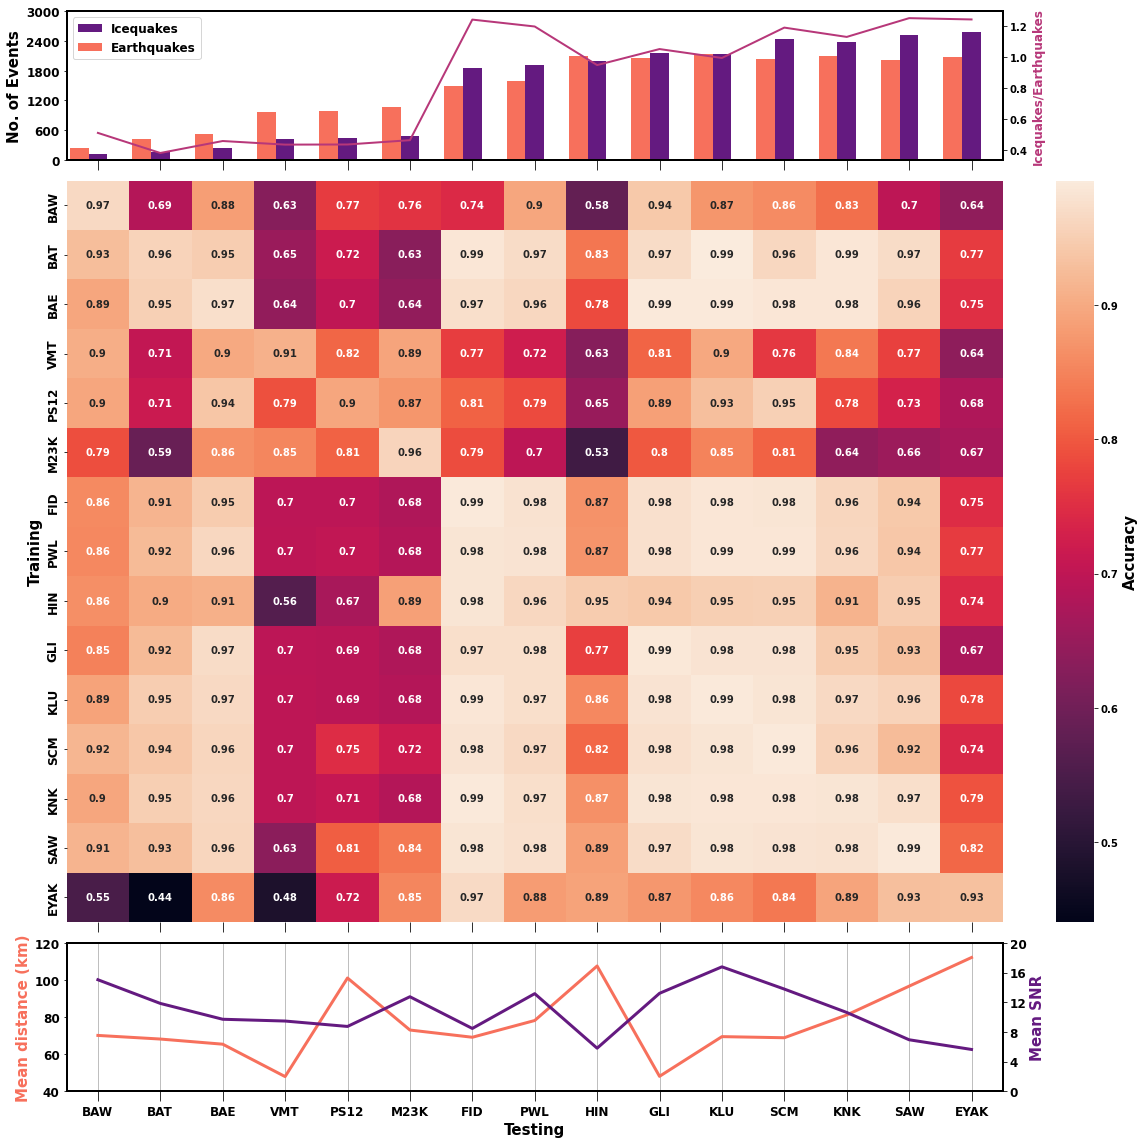

In [34]:
## so acc is a matrix, its rows are the stations, whose data is used for training the model
## and its cols are the stations, whose data is used for testing the model. 
## take care of this, if you are ordering the rows according to an order, you have to order the columns as well. 
acc_order = [acc[i][order] for i in range(len(acc))]
spec_order = [spec[i][order] for i in range(len(acc))]
sens_order = [sens[i][order] for i in range(len(acc))]
## remember above code is just ordering the columns, you still have to order the rows as well. 


## Defining the figure dimensions. 
fig, ((ax, cbar),(ax1, cbar_ax),(ax2,dummy_ax)) = plt.subplots(nrows=3, ncols=2, figsize=(16,16), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1,5,1], 'width_ratios':[25,1]}, facecolor='white')


x = np.linspace(0.5,15,15)



## Extracting colors from a colormap to maintain a constant color scheme

cmap = matplotlib.cm.get_cmap('magma')
c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)
# set width of bar
barWidth = 0.2
# Set position of bar on X axis
br1 = 1.5*np.arange(len(stations))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]


ax_h = sns.heatmap(np.array(acc_order)[order],cbar_ax=cbar_ax,ax=ax1, xticklabels=stations[order], yticklabels=stations[order], annot=True)
cbar_ax.set_ylabel('Accuracy', fontsize=15, fontweight='bold')

#ax_h.set_xticks(x)
#ax.set_xticks(x)
ax_t = ax.twinx()
ax_t.plot(np.arange(15)+0.5, np.array(no_of_icequakes)[order]/np.array(no_of_earthquakes)[order], c=c3, linewidth = 2)
ax_t.set_ylabel('Icequakes/Earthquakes', fontsize = 12, fontweight = 'bold', c=c3)
ax.set_xlim(0,15)
ax.bar(np.arange(15)+0.5, np.array(no_of_icequakes)[order], width=0.3, color = c2, label = 'Icequakes')
ax.bar(np.arange(15)+0.2, np.array(no_of_earthquakes)[order], width=0.3, color = c4, label = "Earthquakes")
ax.set_yticks(np.linspace(0,3000,6))
ax.set_yticklabels([str(int(i)) for i in np.linspace(0,3000,6)],fontsize=12, fontweight='bold')
ax.set_ylabel('No. of Events', fontsize=15, fontweight='bold')
ax.legend(fontsize = 12)

ax2.plot(np.arange(15)+0.5, np.array(dist_array)[order], color=c4, linewidth = 3)
ax2.set_yticks(np.linspace(40,120,5))
ax2.set_yticklabels([str(int(i)) for i in np.linspace(40,120,5)],fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean distance (km)', fontsize=15, fontweight='bold', color=c4)


ax2.set_xticklabels(stations[order],fontsize=12, fontweight='bold')
ax1.set_yticklabels(stations[order],fontsize=12, fontweight='bold')
ax1.set_ylabel('Training', fontsize=15, fontweight='bold')
#ax1.set_xlabel('Testing', fontsize=15, fontweight='bold')
ax1.set_xticks([])

ax3 = ax2.twinx()
ax3.plot(np.arange(15)+0.5, np.array(snr_array)[order], color=c2, linewidth = 3)
ax3.set_yticks(np.linspace(0,20,6))
ax3.set_yticklabels([str(int(i)) for i in np.linspace(0,20,6)],fontsize=12, fontweight='bold')
ax3.set_ylabel('Mean SNR', color=c2, fontsize=15, fontweight='bold')
ax2.set_xlabel('Testing', fontsize=15, fontweight='bold')

cbar.axis('off')
dummy_ax.axis('off')
ax1.set_xticks(np.arange(0.5,15.5,1))
ax2.xaxis.grid()

plt.tight_layout()


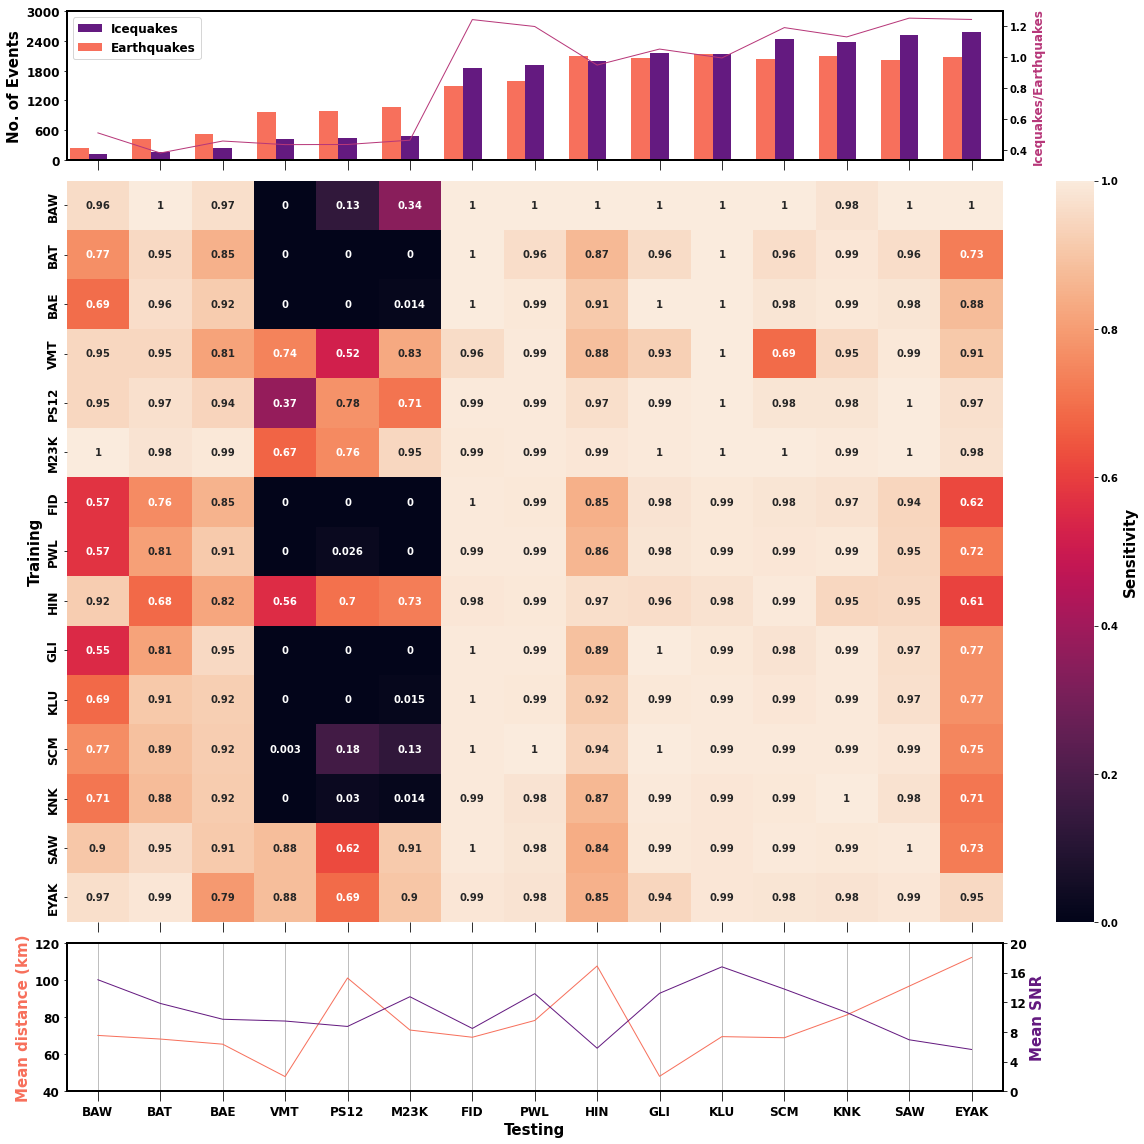

In [35]:
## so acc is a matrix, its rows are the stations, whose data is used for training the model
## and its cols are the stations, whose data is used for testing the model. 
## take care of this, if you are ordering the rows according to an order, you have to order the columns as well. 
acc_order = [acc[i][order] for i in range(len(acc))]
spec_order = [spec[i][order] for i in range(len(acc))]
sens_order = [sens[i][order] for i in range(len(acc))]
## remember above code is just ordering the columns, you still have to order the rows as well. 


## Defining the figure dimensions. 
fig, ((ax, cbar),(ax1, cbar_ax),(ax2,dummy_ax)) = plt.subplots(nrows=3, ncols=2, figsize=(16,16), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1,5,1], 'width_ratios':[25,1]})


x = np.linspace(0.5,15,15)



## Extracting colors from a colormap to maintain a constant color scheme

cmap = matplotlib.cm.get_cmap('magma')
c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)
# set width of bar
barWidth = 0.2
# Set position of bar on X axis
br1 = 1.5*np.arange(len(stations))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]


ax_h = sns.heatmap(np.array(sens_order)[order],cbar_ax=cbar_ax,ax=ax1, xticklabels=stations[order], yticklabels=stations[order], annot=True)
cbar_ax.set_ylabel('Sensitivity', fontsize=15, fontweight='bold')

#ax_h.set_xticks(x)
#ax.set_xticks(x)
ax_t = ax.twinx()
ax_t.plot(np.arange(15)+0.5, np.array(no_of_icequakes)[order]/np.array(no_of_earthquakes)[order], c=c3)
ax_t.set_ylabel('Icequakes/Earthquakes', fontsize = 12, fontweight = 'bold', c=c3)
ax.set_xlim(0,15)
ax.bar(np.arange(15)+0.5, np.array(no_of_icequakes)[order], width=0.3, color = c2, label = 'Icequakes')
ax.bar(np.arange(15)+0.2, np.array(no_of_earthquakes)[order], width=0.3, color = c4, label = "Earthquakes")
ax.set_yticks(np.linspace(0,3000,6))
ax.set_yticklabels([str(int(i)) for i in np.linspace(0,3000,6)],fontsize=12, fontweight='bold')
ax.set_ylabel('No. of Events', fontsize=15, fontweight='bold')
ax.legend(fontsize = 12)

ax2.plot(np.arange(15)+0.5, np.array(dist_array)[order], color=c4)
ax2.set_yticks(np.linspace(40,120,5))
ax2.set_yticklabels([str(int(i)) for i in np.linspace(40,120,5)],fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean distance (km)', fontsize=15, fontweight='bold', color=c4)


ax2.set_xticklabels(stations[order],fontsize=12, fontweight='bold')
ax1.set_yticklabels(stations[order],fontsize=12, fontweight='bold')
ax1.set_ylabel('Training', fontsize=15, fontweight='bold')
#ax1.set_xlabel('Testing', fontsize=15, fontweight='bold')
ax1.set_xticks([])

ax3 = ax2.twinx()
ax3.plot(np.arange(15)+0.5, np.array(snr_array)[order], color=c2)
ax3.set_yticks(np.linspace(0,20,6))
ax3.set_yticklabels([str(int(i)) for i in np.linspace(0,20,6)],fontsize=12, fontweight='bold')
ax3.set_ylabel('Mean SNR', color=c2, fontsize=15, fontweight='bold')
ax2.set_xlabel('Testing', fontsize=15, fontweight='bold')

cbar.axis('off')
dummy_ax.axis('off')
ax1.set_xticks(np.arange(0.5,15.5,1))
ax2.xaxis.grid()

plt.tight_layout()

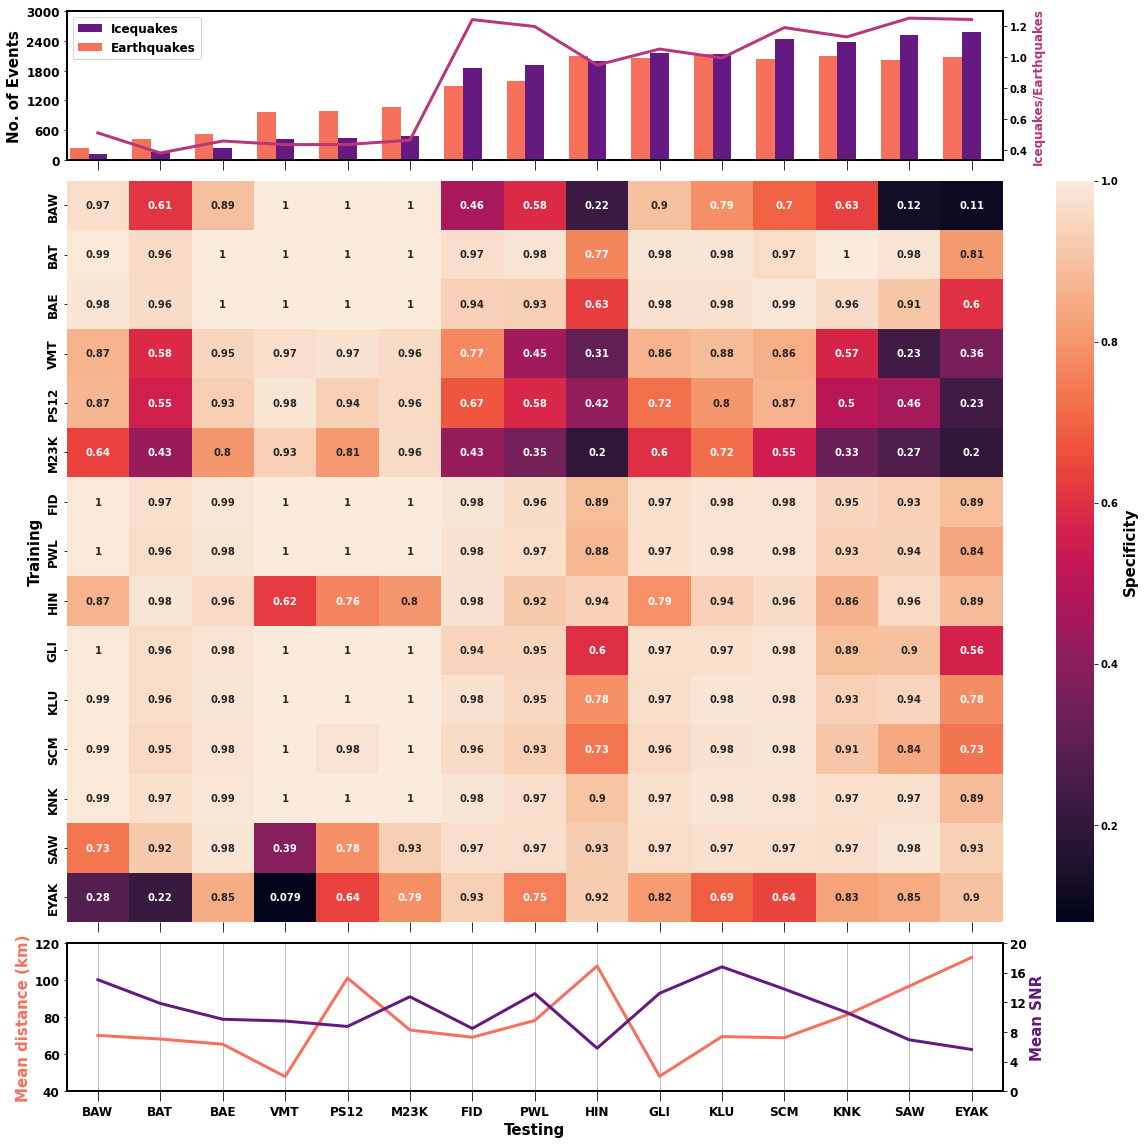

In [349]:
## so acc is a matrix, its rows are the stations, whose data is used for training the model
## and its cols are the stations, whose data is used for testing the model. 
## take care of this, if you are ordering the rows according to an order, you have to order the columns as well. 
acc_order = [acc[i][order] for i in range(len(acc))]
spec_order = [spec[i][order] for i in range(len(acc))]
sens_order = [sens[i][order] for i in range(len(acc))]
## remember above code is just ordering the columns, you still have to order the rows as well. 


## Defining the figure dimensions. 
fig, ((ax, cbar),(ax1, cbar_ax),(ax2,dummy_ax)) = plt.subplots(nrows=3, ncols=2, figsize=(16,16), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1,5,1], 'width_ratios':[25,1]})


x = np.linspace(0.5,15,15)



## Extracting colors from a colormap to maintain a constant color scheme

cmap = matplotlib.cm.get_cmap('magma')
c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)
# set width of bar
barWidth = 0.2
# Set position of bar on X axis
br1 = 1.5*np.arange(len(stations))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]


ax_h = sns.heatmap(np.array(spec_order)[order],cbar_ax=cbar_ax,ax=ax1, xticklabels=stations[order], yticklabels=stations[order], annot=True)
cbar_ax.set_ylabel('Specificity', fontsize=15, fontweight='bold')

#ax_h.set_xticks(x)
#ax.set_xticks(x)
ax_t = ax.twinx()
ax_t.plot(np.arange(15)+0.5, np.array(no_of_icequakes)[order]/np.array(no_of_earthquakes)[order], c=c3)
ax_t.set_ylabel('Icequakes/Earthquakes', fontsize = 12, fontweight = 'bold', c=c3)
ax.set_xlim(0,15)
ax.bar(np.arange(15)+0.5, np.array(no_of_icequakes)[order], width=0.3, color = c2, label = 'Icequakes')
ax.bar(np.arange(15)+0.2, np.array(no_of_earthquakes)[order], width=0.3, color = c4, label = "Earthquakes")
ax.set_yticks(np.linspace(0,3000,6))
ax.set_yticklabels([str(int(i)) for i in np.linspace(0,3000,6)],fontsize=12, fontweight='bold')
ax.set_ylabel('No. of Events', fontsize=15, fontweight='bold')
ax.legend(fontsize = 12)

ax2.plot(np.arange(15)+0.5, np.array(dist_array)[order], color=c4)
ax2.set_yticks(np.linspace(40,120,5))
ax2.set_yticklabels([str(int(i)) for i in np.linspace(40,120,5)],fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean distance (km)', fontsize=15, fontweight='bold', color=c4)


ax2.set_xticklabels(stations[order],fontsize=12, fontweight='bold')
ax1.set_yticklabels(stations[order],fontsize=12, fontweight='bold')
ax1.set_ylabel('Training', fontsize=15, fontweight='bold')
#ax1.set_xlabel('Testing', fontsize=15, fontweight='bold')
ax1.set_xticks([])

ax3 = ax2.twinx()
ax3.plot(np.arange(15)+0.5, np.array(snr_array)[order], color=c2)
ax3.set_yticks(np.linspace(0,20,6))
ax3.set_yticklabels([str(int(i)) for i in np.linspace(0,20,6)],fontsize=12, fontweight='bold')
ax3.set_ylabel('Mean SNR', color=c2, fontsize=15, fontweight='bold')
ax2.set_xlabel('Testing', fontsize=15, fontweight='bold')

cbar.axis('off')
dummy_ax.axis('off')
ax1.set_xticks(np.arange(0.5,15.5,1))
ax2.xaxis.grid()

plt.tight_layout()

### Finding earthquakes and icequakes that were commonly recorded at all the stations. So we can compare their waveforms. 

In [36]:
ind_iq_eq = []
for i in tqdm(range(len(stations))):
    ind_iq_eq.append(compute_ind(stations[i]))

100%|██████████| 15/15 [16:13<00:00, 64.88s/it]


In [37]:
iq_array = [ind_iq_eq[i][0] for i in range(15)]
eq_array = [ind_iq_eq[i][1] for i in range(15)]

In [38]:
from functools import reduce

In [39]:
comm_iq = reduce(np.intersect1d, (iq_array[0], iq_array[1],iq_array[3],iq_array[4],iq_array[5],iq_array[6],
                       iq_array[7],iq_array[8],iq_array[9],iq_array[10],iq_array[11],iq_array[12],
                       iq_array[13],iq_array[14]))

In [40]:
comm_eq = reduce(np.intersect1d, (eq_array[0], eq_array[1],eq_array[3],eq_array[4],eq_array[5],eq_array[6],
                       eq_array[7],eq_array[8],eq_array[9],eq_array[10],eq_array[11],eq_array[12],
                       eq_array[13],eq_array[14]))

In [41]:
pd.read_csv('icequakes_catalog.csv').values[comm_iq][:,4]
    

array([1.4, 1.4, 1.1, 1.1, 1.5, 1.1, 1.3, 1.5, 1.2, 1.0, 1.1, 1.3, 1.3,
       1.4, 1.4, 1.5, 1.6, 1.3, 1.3, 1.3, 1.1, 1.5, 1.3, 1.3, 1.4, 1.6,
       1.1, 1.3, 1.0, 1.3, 0.9, 1.2, 1.0, 1.1, 1.4, 1.4, 1.3, 1.1, 1.2,
       1.2, 1.2, 1.4, 0.8, 1.3, 1.0, 1.0, 1.3, 0.9, 1.1, 1.4, 1.0, 1.4,
       0.9, 1.1, 1.3, 1.1, 1.2, 1.3, 1.4, 1.5, 1.1, 1.3, 1.1, 1.4, 1.3,
       1.2, 1.0, 1.4, 1.1, 1.2, 1.3, 1.3], dtype=object)

In [42]:
pd.read_csv('earthquakes_catalog.csv').values[comm_eq][:,4]

array([1.1, 1.7, 1.6], dtype=object)

In [43]:
print(comm_iq)
print(comm_eq)

[ 52  53  54  65  66  67  68  70  71  72  73  74  75  76  77  78  79  80
  81  83  85  86  87  88  90  91  92  93  94  95  96  97  98  99 100 101
 102 105 106 107 108 115 116 117 118 119 128 129 131 133 134 135 137 138
 140 141 142 143 144 146 147 148 150 151 152 153 154 156 157 158 159 160]
[418 433 501]


In [44]:
stn_new

array(['BAE', 'BAT', 'EYAK', 'FID', 'GLI', 'HIN', 'KLU', 'KNK', 'M23K',
       'PS12', 'PWL', 'SAW', 'SCM', 'VMT'],
      dtype='<U4')

In [45]:
stn_new = np.delete(stations,2)
stn_new 

array(['BAE', 'BAT', 'EYAK', 'FID', 'GLI', 'HIN', 'KLU', 'KNK', 'M23K',
       'PS12', 'PWL', 'SAW', 'SCM', 'VMT'],
      dtype='<U4')

In [50]:
X_iq = []
X_eq = []
t_iq = []
t_eq = []


dur = 1
for i in range(14):
    st_iq = obspy.read('Data/icequake_waveforms/icequake52_'+stn_new[i]+'.mseed')
    st_iq.detrend()
    st_iq.taper(0.01)
    st_iq.filter('bandpass', freqmin=0.5, freqmax=25)
    
    X_iq.append(np.abs(np.fft.fft(st_iq.select(channel='BHZ')[0].data[0:int(dur*60*50)]))/np.max(np.abs(np.fft.fft(st_iq.select(channel='BHZ')[0].data[0:int(dur*60*50)])))) 
    t_iq.append(st_iq.select(channel='BHZ')[0])
    
    
    st_eq = obspy.read('Data/earthquake_waveforms/earthquake_433_'+stn_new[i]+'.mseed')
    st_eq.detrend()
    st_eq.taper(0.01)
    st_eq.filter('bandpass', freqmin=0.5, freqmax=25)
    
    t_eq.append(st_eq.select(channel='BHZ')[0])
    X_eq.append(np.abs(np.fft.fft(st_eq.select(channel='BHZ')[0].data[0:int(dur*60*50)]))/np.max(np.abs(np.fft.fft(st_eq.select(channel='BHZ')[0].data[0:int(dur*60*50)]))))    

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


In [51]:
val = pd.read_csv('icequakes_catalog.csv').values[52]
time_iq, lat_iq, lon_iq, depth_iq, mag_iq  = val[0], val[1], val[2], val[3], val[4]

val = pd.read_csv('earthquakes_catalog.csv').values[433]
time_eq, lat_eq, lon_eq, depth_eq, mag_eq  = val[0], val[1], val[2], val[3], val[4]

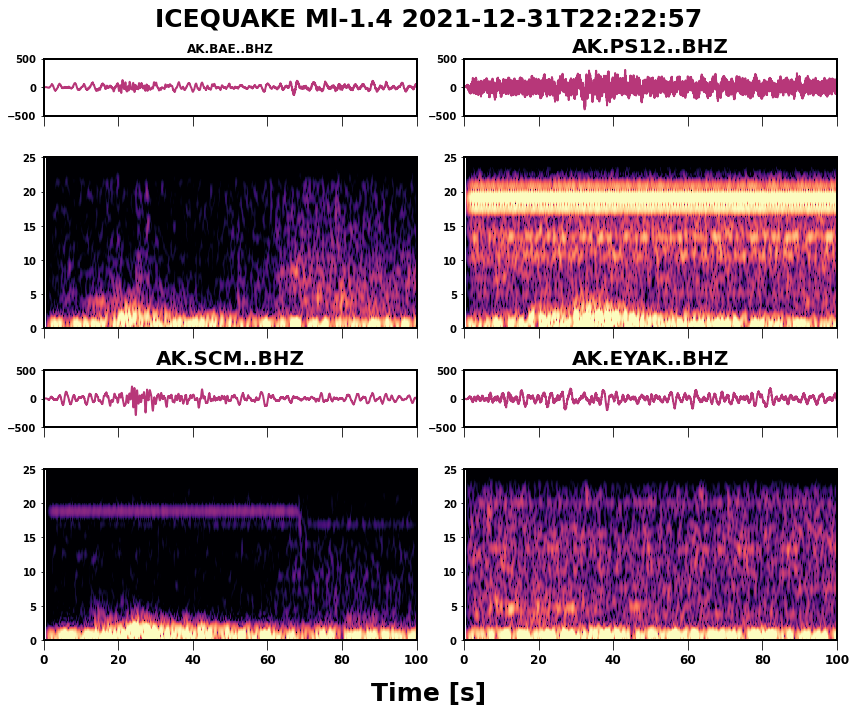

In [52]:
fig, ax= plt.subplots(nrows=4, ncols=2, figsize=(12,10), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1,3,1,3], 'width_ratios':[1,1]})



l1 = 0
l2 = 25
time = t_iq[0].times()
ax[0][0].plot(time, t_iq[0].data, lw=2, color = c3)
ax[0][0].set_ylim(-500,500)
ax[0][0].set_xlim(0,100)
ax[0][0].set_title(t_iq[0].id, fontsize = 12, fontweight = 'bold')
yax = t_iq[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][0])
ax[1][0].set_xlim(0,100)
ax[1][0].set_ylim(l1,l2)
im = yax.images[0]
im.set_clim(vmin=-10,vmax=30)



ax[0][1].plot(time, t_iq[9].data, lw = 2, color = c3)
ax[0][1].set_ylim(-500,500)
ax[0][1].set_xlim(0,100)
ax[0][1].set_title(t_iq[9].id, fontsize = 20, fontweight = 'bold')
yax = t_iq[9].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][1])
ax[1][1].set_xlim(0,100)
ax[1][1].set_ylim(l1,l2)
im = yax.images[0]
im.set_clim(vmin=-10,vmax=30)



ax[2][0].plot(time, t_iq[12].data, lw = 2, color = c3)
ax[2][0].set_ylim(-500,500)
ax[2][0].set_xlim(0,100)
ax[2][0].set_title(t_iq[12].id, fontsize = 20, fontweight = 'bold')
yax = t_iq[12].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][0])
ax[3][0].set_xlim(0,100)
ax[3][0].set_ylim(l1,l2)
im = yax.images[0]
im.set_clim(vmin=-10,vmax=30)



ax[2][1].plot(time, t_iq[2].data, lw = 2, color = c3)
ax[2][1].set_ylim(-500,500)
ax[2][1].set_xlim(0,100)
ax[2][1].set_title(t_iq[2].id, fontsize = 20, fontweight = 'bold')
yax = t_iq[2].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][1], clip = (0.2,1))
ax[3][1].set_xlim(0,100)
ax[3][1].set_ylim(l1,l2)
im = yax.images[0]
im.set_clim(vmin=-10,vmax=30)



fig.suptitle('ICEQUAKE'+' Ml-'+str(mag_iq)+' '+str(time_iq)[0:19], fontsize = 25, fontweight='bold')
fig.supxlabel('Time [s]', fontsize = 25, fontweight = 'bold')
fig.tight_layout()

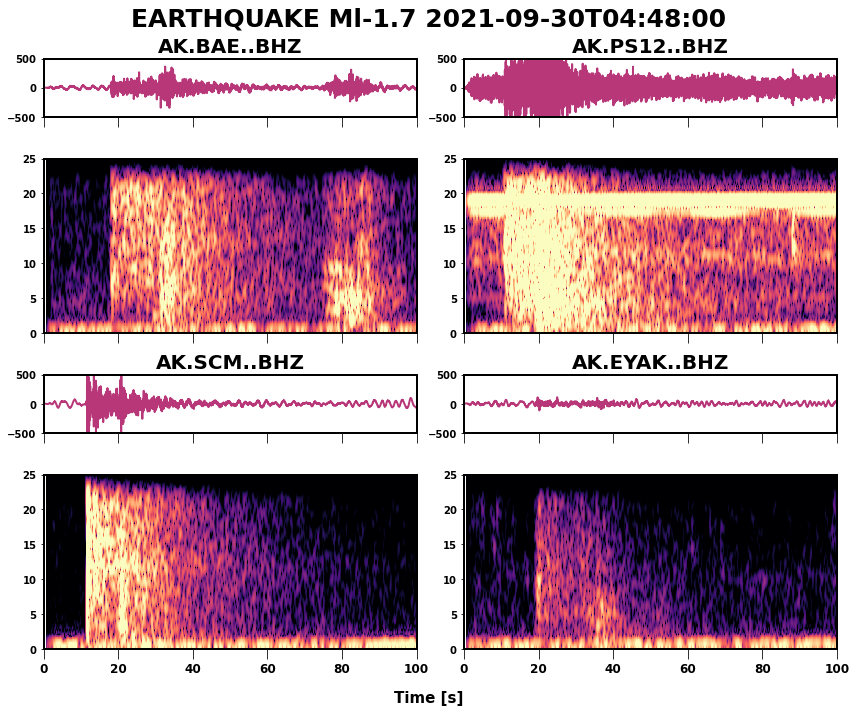

In [56]:
fig, ax= plt.subplots(nrows=4, ncols=2, figsize=(12,10), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1,3,1,3], 'width_ratios':[1,1]})


l1 = 0
l2 = 25

ax[0][0].plot(time, t_eq[0].data, lw=2, color = c3)
ax[0][0].set_ylim(-500,500)
ax[0][0].set_xlim(0,100)
ax[0][0].set_title(t_eq[0].id, fontsize = 20, fontweight = 'bold')
yax = t_eq[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][0])
ax[1][0].set_xlim(0,100)
ax[1][0].set_ylim(l1,l2)
im = yax.images[0]
im.set_clim(vmin=-10,vmax=30)

ax[0][1].plot(time, t_eq[9].data, lw = 2, color = c3)
ax[0][1].set_ylim(-500,500)
ax[0][1].set_xlim(0,100)
ax[0][1].set_title(t_eq[9].id, fontsize = 20, fontweight = 'bold')
yax = t_eq[9].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][1])
ax[1][1].set_xlim(0,100)
ax[1][1].set_ylim(l1,l2)
im = yax.images[0]
im.set_clim(vmin=-10,vmax=30)

ax[2][0].plot(time, t_eq[12].data, lw = 2, color = c3)
ax[2][0].set_ylim(-500,500)
ax[2][0].set_xlim(0,100)
ax[2][0].set_title(t_eq[12].id, fontsize = 20, fontweight = 'bold')
yax = t_eq[12].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][0])
ax[3][0].set_xlim(0,100)
ax[3][0].set_ylim(l1,l2)
im = yax.images[0]
im.set_clim(vmin=-10,vmax=30)

ax[2][1].plot(time, t_eq[2].data, lw = 2, color = c3)
ax[2][1].set_ylim(-500,500)
ax[2][1].set_xlim(0,100)
ax[2][1].set_title(t_eq[2].id, fontsize = 20, fontweight = 'bold')
yax = t_eq[2].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][1], clip = (0.2,1))
ax[3][1].set_xlim(0,100)
ax[3][1].set_ylim(l1,l2)
im = yax.images[0]
im.set_clim(vmin=-10,vmax=30)



fig.suptitle('EARTHQUAKE'+' Ml-'+str(mag_eq)+' '+str(time_eq)[0:19], fontsize = 25, fontweight='bold')
fig.supxlabel('Time [s]', fontsize = 15, fontweight = 'bold')
fig.tight_layout()

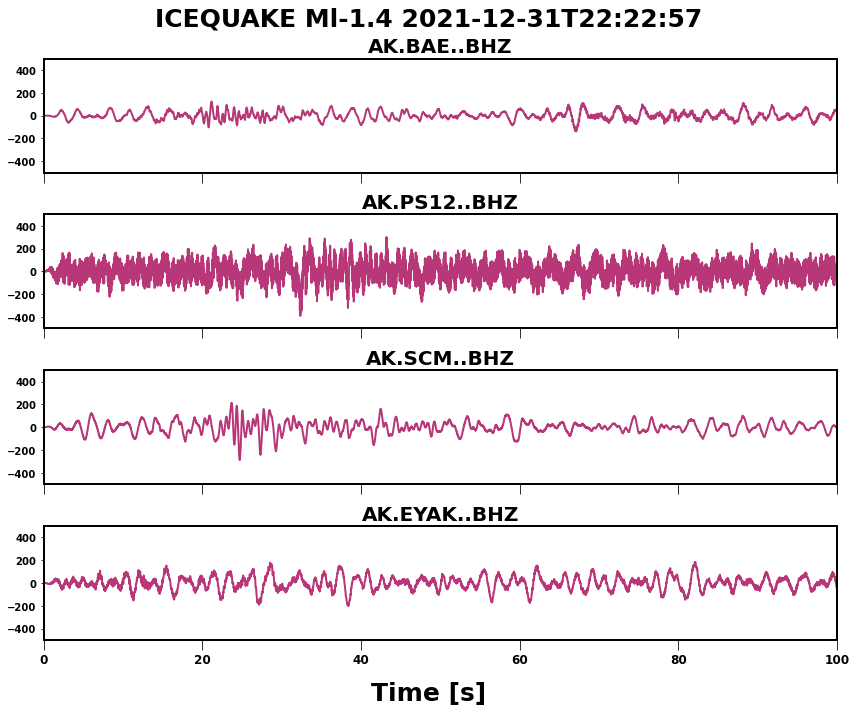

In [53]:
fig, ax= plt.subplots(nrows=4, ncols=1, figsize=(12,10), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1,1,1,1]})



l1 = 0
l2 = 25
time = t_iq[0].times()
ax[0].plot(time, t_iq[0].data, lw=2, color = c3)
ax[0].set_ylim(-500,500)
ax[0].set_xlim(0,100)
ax[0].set_title(t_iq[0].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][0])
#ax[1][0].set_xlim(0,100)
#ax[1][0].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



ax[1].plot(time, t_iq[9].data, lw = 2, color = c3)
ax[1].set_ylim(-500,500)
ax[1].set_xlim(0,100)
ax[1].set_title(t_iq[9].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[9].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][1])
#ax[1][1].set_xlim(0,100)
#ax[1][1].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



ax[2].plot(time, t_iq[12].data, lw = 2, color = c3)
ax[2].set_ylim(-500,500)
ax[2].set_xlim(0,100)
ax[2].set_title(t_iq[12].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[12].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][0])
#ax[3][0].set_xlim(0,100)
#ax[3][0].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



ax[3].plot(time, t_iq[2].data, lw = 2, color = c3)
ax[3].set_ylim(-500,500)
ax[3].set_xlim(0,100)
ax[3].set_title(t_iq[2].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[2].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][1], clip = (0.2,1))
#ax[3][1].set_xlim(0,100)
#ax[3][1].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



fig.suptitle('ICEQUAKE'+' Ml-'+str(mag_iq)+' '+str(time_iq)[0:19], fontsize = 25, fontweight='bold')
fig.supxlabel('Time [s]', fontsize = 25, fontweight = 'bold')
fig.tight_layout()

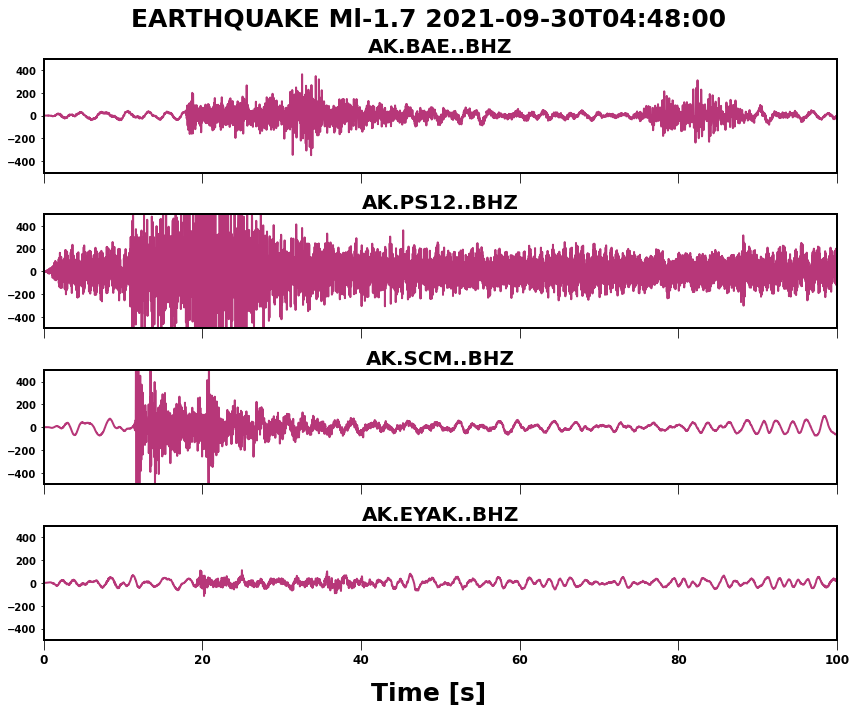

In [54]:
fig, ax= plt.subplots(nrows=4, ncols=1, figsize=(12,10), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1,1,1,1]})



l1 = 0
l2 = 25
time = t_eq[0].times()
ax[0].plot(time, t_eq[0].data, lw=2, color = c3)
ax[0].set_ylim(-500,500)
ax[0].set_xlim(0,100)
ax[0].set_title(t_eq[0].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][0])
#ax[1][0].set_xlim(0,100)
#ax[1][0].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



ax[1].plot(time, t_eq[9].data, lw = 2, color = c3)
ax[1].set_ylim(-500,500)
ax[1].set_xlim(0,100)
ax[1].set_title(t_eq[9].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[9].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][1])
#ax[1][1].set_xlim(0,100)
#ax[1][1].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



ax[2].plot(time, t_eq[12].data, lw = 2, color = c3)
ax[2].set_ylim(-500,500)
ax[2].set_xlim(0,100)
ax[2].set_title(t_eq[12].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[12].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][0])
#ax[3][0].set_xlim(0,100)
#ax[3][0].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



ax[3].plot(time, t_eq[2].data, lw = 2, color = c3)
ax[3].set_ylim(-500,500)
ax[3].set_xlim(0,100)
ax[3].set_title(t_eq[2].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[2].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][1], clip = (0.2,1))
#ax[3][1].set_xlim(0,100)
#ax[3][1].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



fig.suptitle('EARTHQUAKE'+' Ml-'+str(mag_eq)+' '+str(time_eq)[0:19], fontsize = 25, fontweight='bold')
fig.supxlabel('Time [s]', fontsize = 25, fontweight = 'bold')
fig.tight_layout()

## Plotting the location of above icequake and earthquake

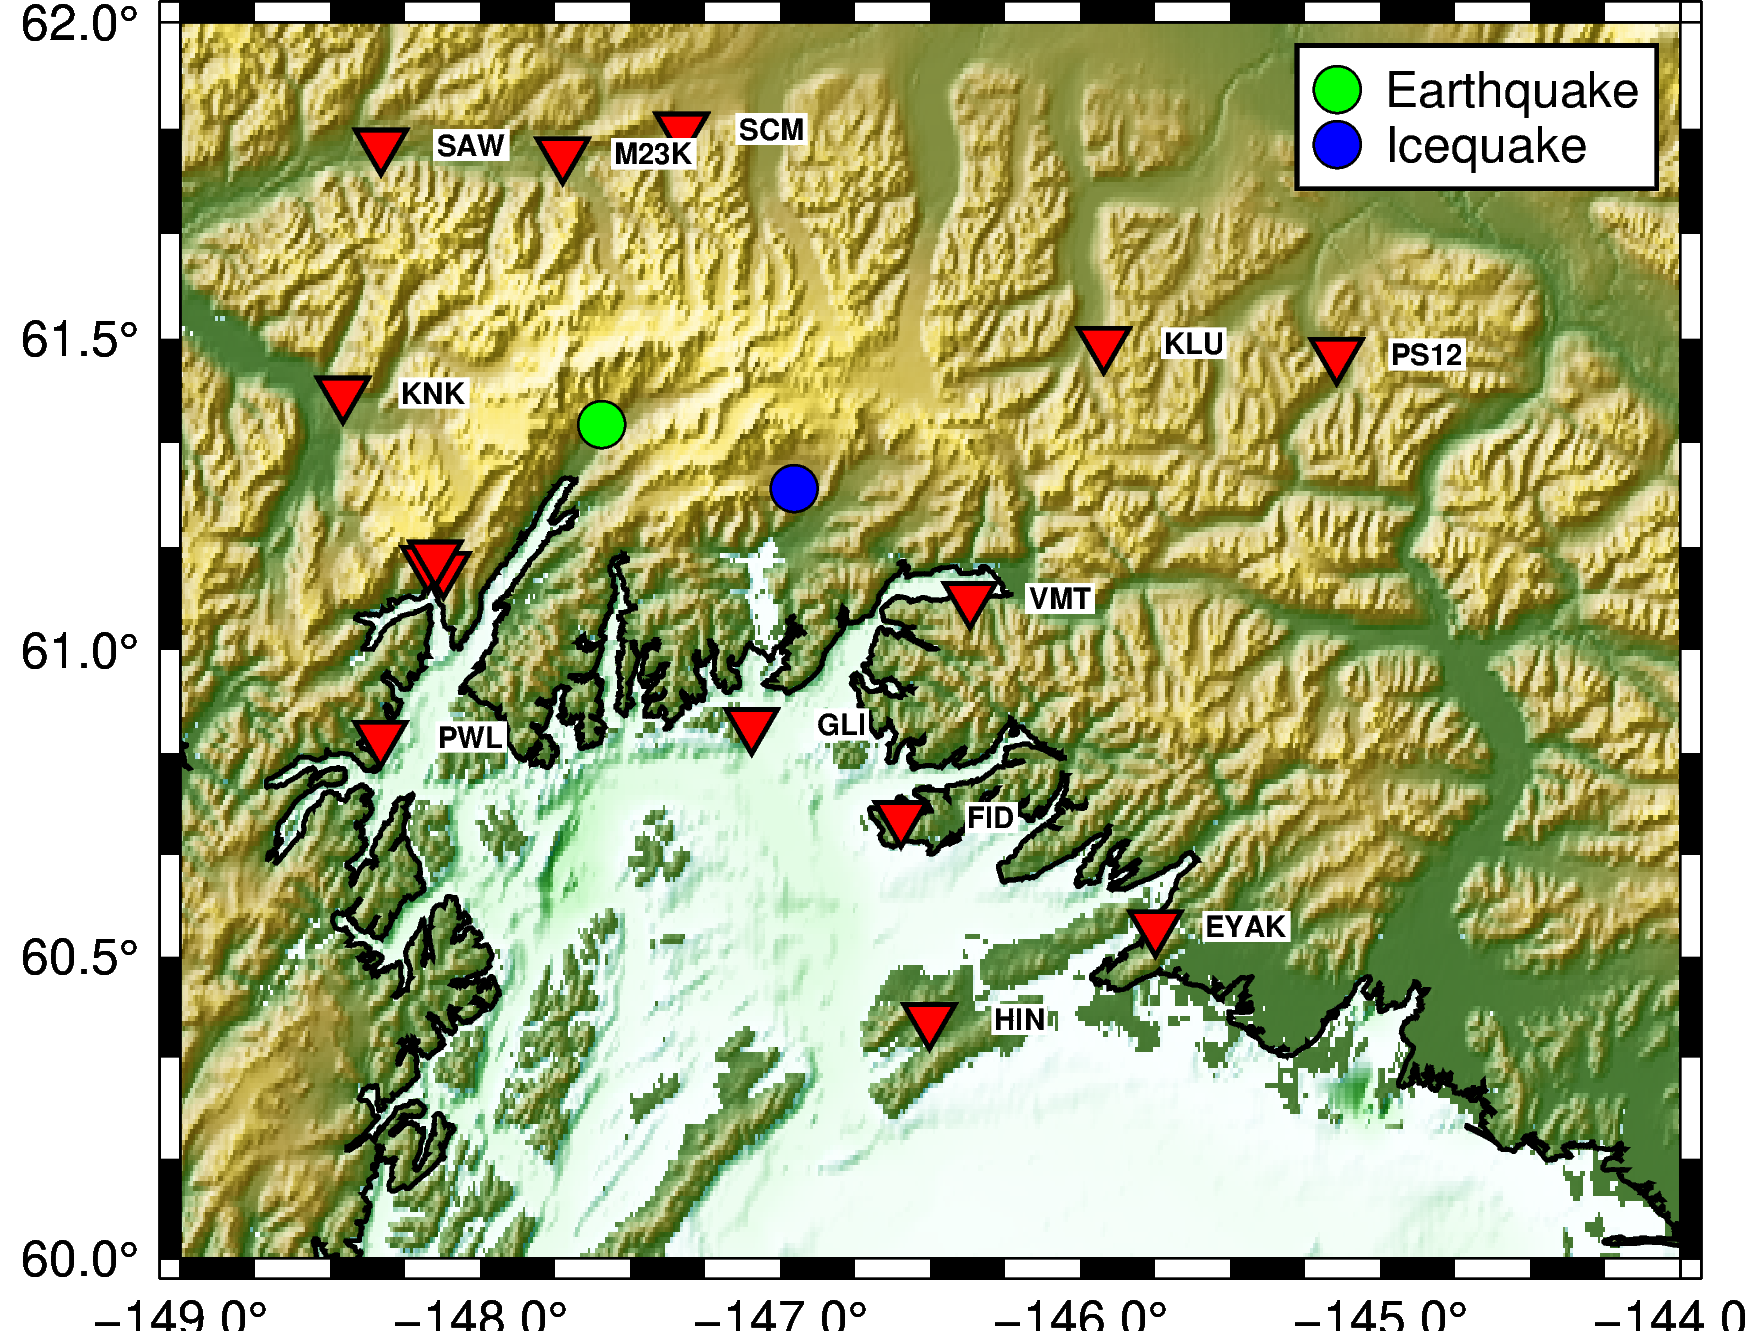

In [295]:
region = [-149.0, -144, 60, 62]
fig = pygmt.Figure()
pygmt.makecpt(cmap='relief',series='-5000/5000/1000',continuous=True)
topo_data = '@earth_relief_30s'
pygmt.config(FORMAT_GEO_MAP="ddd.x")
fig.grdimage(grid=topo_data,region=region,projection='M5i',shading=True,cmap=True,
            frame=["WSne", "xaf", "yaf"])
#pygmt.makecpt(cmap="plasma", series=[np.min(depths),25])
fig.coast(area_thresh = 10000,
    shorelines='1p,black',
#          water="lightblue",
          region=region,
#          borders="1/thick",
         frame=["WSne", "xaf", "yaf"], )

#fig.colorbar(frame='af+l"Elevation(m)"')
pygmt.makecpt(cmap="plasma", series = [70,100])

fig.plot(x=eqlon,y=eqlat,style='c0.4c',color='green',pen='0.5p,black',
         region=region, label='Earthquake')
fig.plot(x=iqlon,y=iqlat,style='c0.4c',color='blue',pen='0.5p,black',
         region=region, label='Icequake')
fig.plot(x=stn_lons, y=stn_lats,style='i0.5c',color='red',pen='1p,black',
         region=region, cmap=False)
#fig.plot(x=gl_lons,y=gl_lats,style='a0.6c',color='yellow',pen='0.5p,black',
#         region=region)
#fig.text(text=glaciers, y=gl_lats, x=np.array(gl_lons)+0.2,font="7p,Helvetica-Bold,black",fill='white')
fig.text(text=stations[3:],y=stn_lats[3:]+0.00,x=stn_lons[3:]+0.30,font="7p,Helvetica-Bold,black",fill='white')
fig.legend()



fig.show()

### Comparing the waveforms of icequakes and earthquakes at different stations

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9

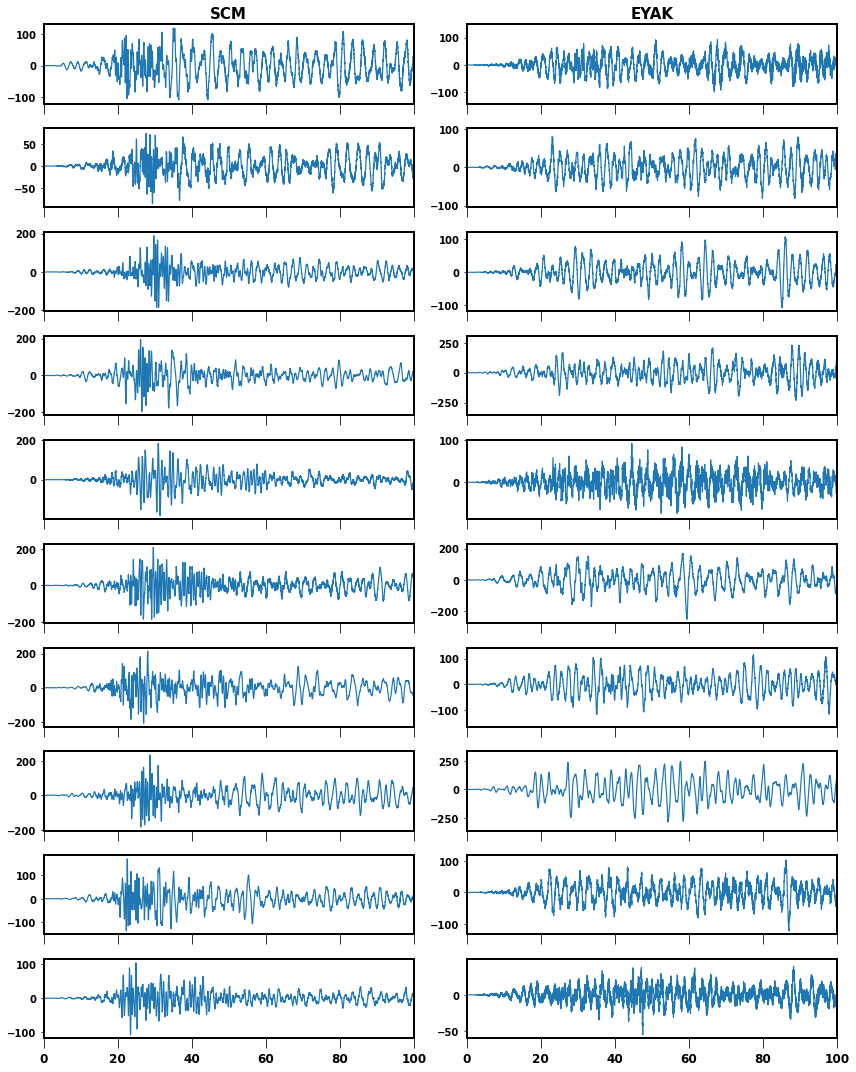

In [57]:
fig, ax= plt.subplots(nrows=10, ncols=2, figsize=(12,15), sharex='col', gridspec_kw=
                                                   { 'width_ratios':[1,1]})


station = 'SCM'
x = random.sample(range(100), 10)
r = np.array(glob('Data/icequake_waveforms/*'+station+'*'))[x]

station1 = 'EYAK'
x1 = random.sample(range(100), 10)
r1 = np.array(glob('Data/icequake_waveforms/*'+station1+'*'))[x]



for i in range(10):
    st = obspy.read(r[i])
    st.taper(0.1)
    st.filter('bandpass', freqmin=0.5, freqmax=25)
    time = st[0].times()
    ax[i][0].plot(time, st[0].data, lw=1.2)
    ax[i][0].set_xlim(0,100)
    #ax[i][0].set_ylim(-500,500)
    ax[0][0].set_title(station, fontsize=15, fontweight = 'bold')
    

    st1 = obspy.read(r1[i])
    st1.taper(0.1)
    st1.filter('bandpass', freqmin=0.5, freqmax=25)
    time = st1[0].times()
    ax[i][1].plot(time, st1[0].data, lw=1.2)
    ax[i][1].set_xlim(0,100)
    #ax[i][1].set_ylim(-500,500)
    ax[0][1].set_title(station1, fontsize=15, fontweight = 'bold')    
    
    
    
fig.tight_layout()

## Comparing the spectrograms of icequakes and earthquakes at different stations. 

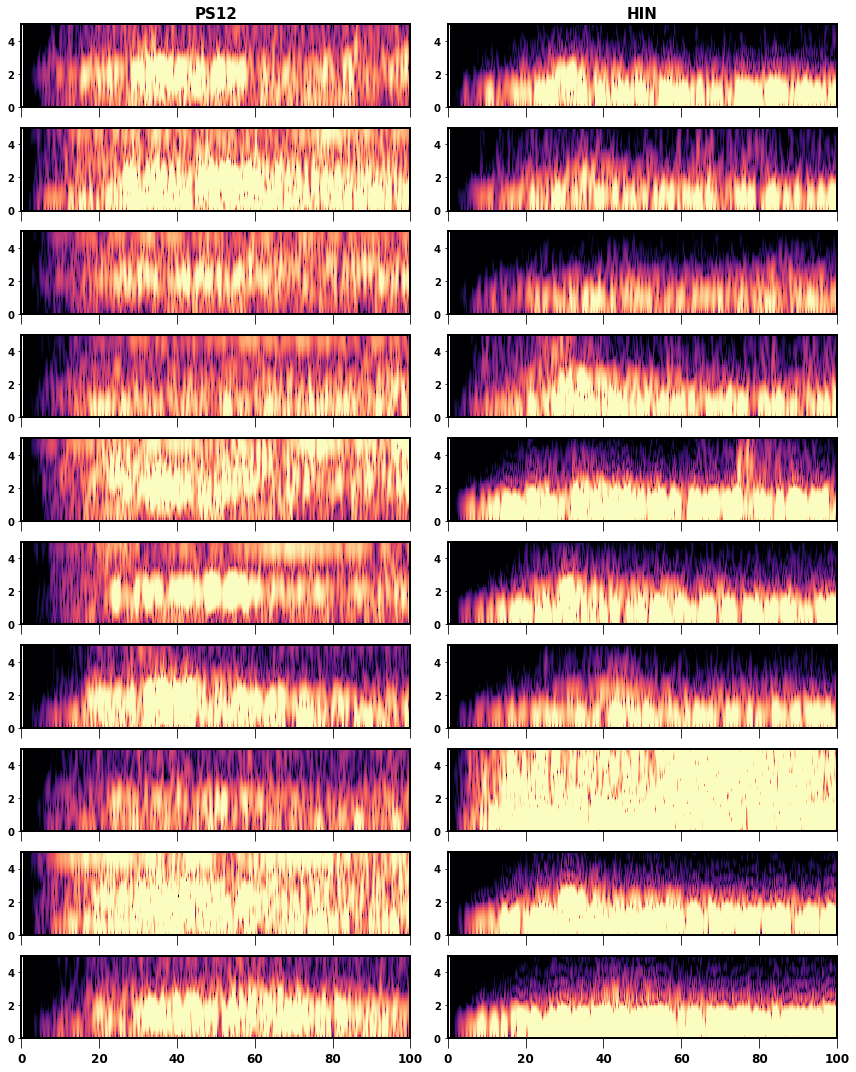

In [59]:
fig, ax= plt.subplots(nrows=10, ncols=2, figsize=(12,15), sharex='col', gridspec_kw=
                                                   { 'width_ratios':[1,1]})


station = 'PS12'
x = random.sample(range(100), 10)
r = np.array(glob('Data/icequake_waveforms/*'+station+'*'))[x]


station1 = 'HIN'
x1 = random.sample(range(100), 10)
r1 = np.array(glob('Data/icequake_waveforms/*'+station1+'*'))[x1]


for i in range(10):
    st = obspy.read(r[i])
    st.taper(0.1)
    st.filter('bandpass', freqmin=0.5, freqmax=5)
    time = st[0].times()
    yax = st[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[i][0])
    im = yax.images[0]
    im.set_clim(vmin=-10,vmax=30)    
    
    #ax[i][0].plot(time, st[0].data, lw=1.2)
    ax[i][0].set_xlim(0,100)
    ax[i][0].set_ylim(0,5)
    ax[0][0].set_title(station, fontsize=15, fontweight = 'bold')
    
    
    
    st1 = obspy.read(r1[i])
    st1.taper(0.1)
    st1.filter('bandpass', freqmin=0.5, freqmax=5)
    time = st1[0].times()
    yax = st1[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[i][1])
    im = yax.images[0]
    im.set_clim(vmin=-10,vmax=30)    
    
    #ax[i][0].plot(time, st[0].data, lw=1.2)
    ax[i][1].set_xlim(0,100)
    ax[i][1].set_ylim(0,5)
    ax[0][1].set_title(station1, fontsize=15, fontweight = 'bold')    
fig.tight_layout()

## Comparing the spectrograms of earthquakes and icequakes at same station

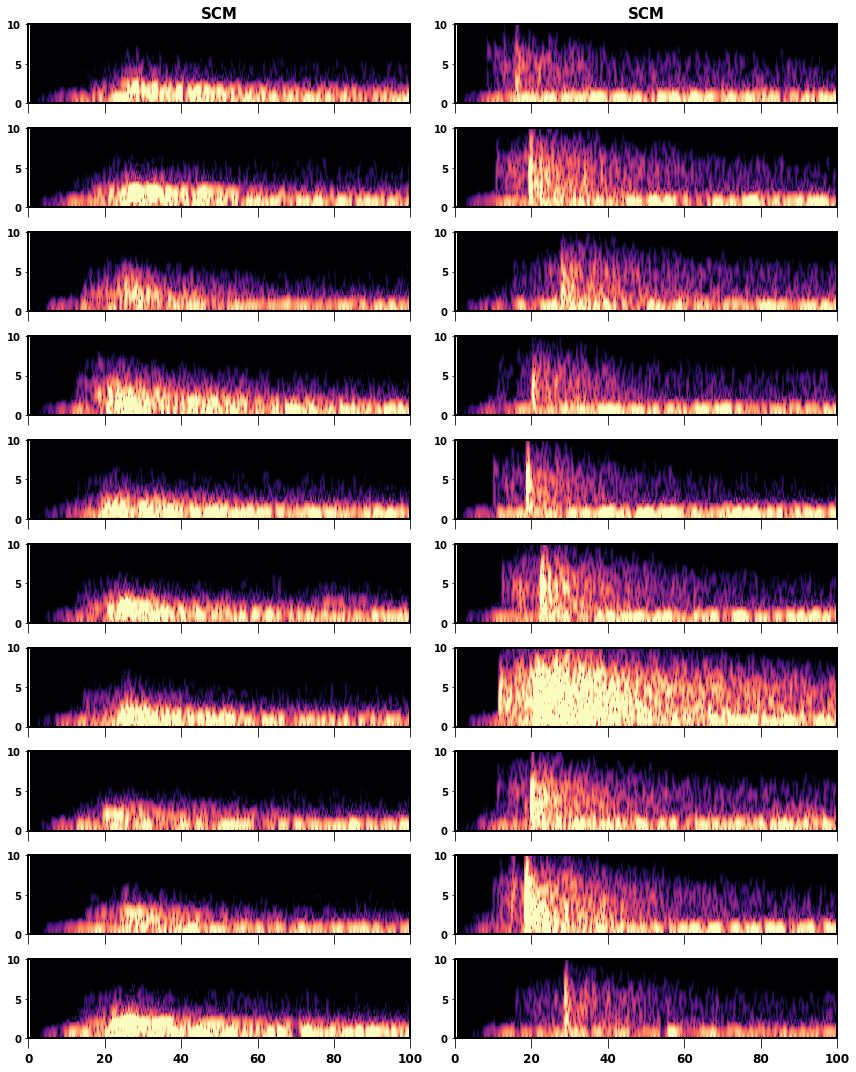

In [61]:
fig, ax= plt.subplots(nrows=10, ncols=2, figsize=(12,15), sharex='col', gridspec_kw=
                                                   { 'width_ratios':[1,1]})


station = 'SCM'
x = random.sample(range(100), 10)
r = np.array(glob('Data/icequake_waveforms/*'+station+'*'))[x]


station1 = 'SCM'
x1 = random.sample(range(100), 10)
r1 = np.array(glob('Data/earthquake_waveforms/*'+station1+'*'))[x1]


for i in range(10):
    st = obspy.read(r[i])
    st.taper(0.1)
    st.filter('bandpass', freqmin=0.5, freqmax=5)
    time = st[0].times()
    yax = st[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[i][0])
    im = yax.images[0]
    im.set_clim(vmin=-10,vmax=30)    
    
    #ax[i][0].plot(time, st[0].data, lw=1.2)
    ax[i][0].set_xlim(0,100)
    ax[i][0].set_ylim(0,10)
    ax[0][0].set_title(station, fontsize=15, fontweight = 'bold')
    
    
    
    st1 = obspy.read(r1[i])
    st1.taper(0.1)
    st1.filter('bandpass', freqmin=0.5, freqmax=5)
    time = st1[0].times()
    yax = st1[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[i][1])
    im = yax.images[0]
    im.set_clim(vmin=-10,vmax=30)    
    
    #ax[i][0].plot(time, st[0].data, lw=1.2)
    ax[i][1].set_xlim(0,100)
    ax[i][1].set_ylim(0,10)
    ax[0][1].set_title(station1, fontsize=15, fontweight = 'bold')    
fig.tight_layout()